# Loading T-5

In [1]:
from transformers import AutoTokenizer, T5EncoderModel
import nltk

tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = T5EncoderModel.from_pretrained("t5-base")
input_ids = tokenizer("I love you", return_tensors="pt").input_ids  # Batch size 1
outputs = model(input_ids=input_ids)
last_hidden_states = outputs.last_hidden_state
sentence_embedding = last_hidden_states.mean(dim=1)

/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5_fast.py:155: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-base were not used when initializing T5EncoderModel: ['decoder.block.10.layer.1.EncDecAttention.v.weight', 'decoder.block.2.layer.1.EncDecAttention.k.weight', 'decoder.block

In [2]:
last_hidden_states.shape

torch.Size([1, 4, 768])

# Reading Meta

In [2]:
import json
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

meta_df = getDF('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/raw/meta_AMAZON_FASHION.json.gz')

In [3]:
title_dict = {} # asin => title
drop_item_num = 0
for i in range(len(meta_df)):
    row = meta_df.iloc[i]
    title = row['title']
    if not pd.isna(title):
        if title[:39] == 'var aPageStart = (new Date()).getTime()':
            drop_item_num += 1
            continue
        title_dict[row['asin']]=row['title']
    else:
        drop_item_num += 1
print(drop_item_num,'item dropped')
title_corpus = [i[1].lower() for i in title_dict.items()]

435 item dropped


In [4]:
# pre-process sentences. (1) removing stop words

# nltk.download('stopwords')
stopwords = list(nltk.corpus.stopwords.words('english'))
stopwords.extend(['!','"','#','$','%','&','(',')','*','+',',','.','/',':',';','<','=','>','?','@','[','\\',']','^','_','`','{','|','}','~','\t','\n'])

for i in range(len(title_corpus)):
    sentence = title_corpus[i]
    tokens = tokenizer.tokenize(sentence)
    tokens_without_stopwords = [token for token in tokens if token.lower() not in stopwords]
    preprocessed_sentence = ' '.join(tokens_without_stopwords)
    title_corpus[i] = preprocessed_sentence

In [5]:
inputs = tokenizer(title_corpus[:10], return_tensors="pt", padding=True, truncation=True)  # Batch size 1
attention_mask = inputs['attention_mask']
input_ids = inputs.input_ids

In [6]:
outputs = model(input_ids=input_ids)
encoded_sentence = model(input_ids, attention_mask)
last_hidden_states = encoded_sentence.last_hidden_state
sentence_embedding = last_hidden_states.mean(dim=1)

In [7]:
sentence_embedding.shape

torch.Size([10, 768])

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X, 50)

In [81]:
from sklearn.cluster import MiniBatchKMeans
CLUSTER_NUM = 20

kmeans = MiniBatchKMeans(n_clusters=CLUSTER_NUM, init_size=512, batch_size=1024, random_state=2023)
kmeans.fit(X)
clusters = kmeans.predict(X)

In [ ]:
### SAVE ###
import pickle
pickle.dump(title_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/asin_title_dict.pickle', 'wb'))
pickle.dump(clusters_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/asin_clusters{}_dict.pickle'.format(CLUSTER_NUM), 'wb'))
pickle.dump(cluster_topic_dict, open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/cluster{}_topic_dict.pickle'.format(CLUSTER_NUM), 'wb'))

/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/holdenhu/miniconda3/envs/recbole/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


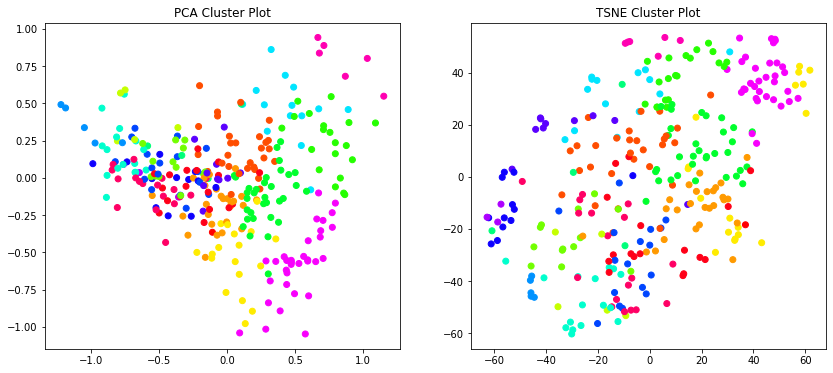

In [22]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm


def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:])
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items,:]))
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(X, clusters)

In [5]:
### Load
import pickle
asin_clusters20_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/asin_clusters20_dict.pickle', 'rb'))
asin_title_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/asin_title_dict.pickle', 'rb'))
cluster20_topic_dict = pickle.load(open('/ssd1/holdenhu/Amazon_dataset/Amazon_Fashion/processed/text/cluster20_topic_dict.pickle', 'rb'))

In [15]:
import pickle
# asin_list, text_corpus
info_dict = pickle.load(open('/ssd1/holdenhu/ML_dataset/ml-1m/raw/info_dict.txt', 'rb'))

In [11]:
import json
asin_list, text_list = [], []
for asin, info in info_dict.items():
    info_json = json.loads(info)
    if 'description' in info_json:
        asin_list.append(asin)
        text_list.append(info_json['description'])